<a href="https://colab.research.google.com/github/issacridhin/LabWorks/blob/Case-Study-CV_NLP_DL/2348546_DL_CV_NLP_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
import nltk
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split
import torch.optim as optim
from transformers import BertTokenizer, BertModel
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ridhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ridhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Load and Preprocess the Data
function to load the data from CSV.
Preprocess text data using BERT

In [ ]:
def load_text_data(file_path):
    try:
        return pd.read_csv(file_path, on_bad_lines='skip')
    except Exception as e:
        print(f"Failed to load CSV: {e}")
        return None

def load_bert_model(model_name="bert-base-uncased"):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    return tokenizer, model

def get_bert_embeddings(texts, tokenizer, model, device='cpu'):
    model.to(device)
    model.eval()
    embeddings = []
    with torch.no_grad():
        for text in texts:
            # Ensure text is a string
            text = str(text) if pd.notnull(text) else ""
            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
            outputs = model(**inputs)
            hidden_states = outputs.last_hidden_state
            mean_embedding = torch.mean(hidden_states, dim=1).squeeze().cpu().numpy()
            embeddings.append(mean_embedding)
    return np.array(embeddings)


In [ ]:
#load and preprocess image data.

In [ ]:
def load_and_preprocess_image(image_path, size=(64, 64)):
    if not os.path.exists(image_path):
        return None
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB').resize(size)
            img_array = np.array(img, dtype=np.float32) / 255.0
            return img_array
    except IOError:
        print(f"Error opening or processing image {image_path}")
        return None

In [ ]:
#Image Generation

In [ ]:
def dataset_generator(text_file_path, image_folder_path, tokenizer, model, batch_size=32):
    data = load_text_data(text_file_path)
    if data is None or data.empty:
        print("No data available or data loading failed.")
        return

    current_year = data['year'].max()
    popular_seasons = ['Summer', 'Winter']
    data['y'] = ((data['year'] == current_year) & data['season'].isin(popular_seasons)).astype(int)

    data['productDisplayName'] = data['productDisplayName'].astype(str)
    text_features = get_bert_embeddings(data['productDisplayName'].tolist(), tokenizer, model)

    batch_images = []
    batch_text_features = []
    batch_y = []
    indices = []

    for idx, row in data.iterrows():
        image_path = os.path.join(image_folder_path, f"{row['id']}.jpg")
        image_array = load_and_preprocess_image(image_path)
        if image_array is not None:
            batch_images.append(image_array)
            batch_text_features.append(text_features[idx])
            batch_y.append(row['y'])
            indices.append(idx)
            if len(batch_images) == batch_size:
                yield np.array(batch_text_features), np.array(batch_images), np.array(batch_y)
                batch_images, batch_text_features, batch_y = [], [], []

    if batch_images:
        yield np.array(batch_text_features), np.array(batch_images), np.array(batch_y)


In [ ]:
tokenizer, bert_model = load_bert_model()

In [ ]:
#Loading the dataset and the image file path

In [ ]:
dataset_path = r'styles.csv'
image_path = r'e-commerce\images'

In [ ]:
gen = dataset_generator(dataset_path, image_path, tokenizer, bert_model, batch_size=32)

In [ ]:
text_features, image_data_batch, y_batch = next(gen)

ResNet50 for feature extraction

C:\Users\ridhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ridhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing batch 1/1


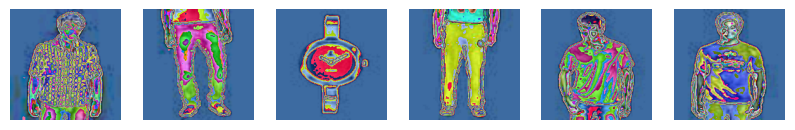

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

def extract_features_and_display_images(images, model_name="resnet50", batch_size=32, device='cpu', num_images_to_display=6):
    model = getattr(models, model_name)(pretrained=True)
    model = nn.Sequential(*list(model.children())[:-1])
    model.to(device)
    model.eval()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    transformed_images = [transform(image) for image in images]
    dataset = CustomImageDataset(transformed_images)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    features = []
    plt.figure(figsize=(10, 5))
    with torch.no_grad():
        for batch_index, imgs in enumerate(loader):
            print(f"Processing batch {batch_index + 1}/{len(loader)}")
            imgs = imgs.to(device)
            feats = model(imgs)
            feats = feats.view(feats.size(0), -1)
            features.append(feats.cpu().numpy())

            if batch_index == 0:
                for i, image in enumerate(imgs.cpu()):
                    if i >= num_images_to_display:
                        break
                    plt.subplot(1, num_images_to_display, i + 1)
                    plt.imshow(transforms.ToPILImage()(image))
                    plt.axis('off')
        plt.show()

    return np.vstack(features)

visual_features = extract_features_and_display_images(image_data_batch)



Combining BERT embeddings and ReSnet 50 image features

In [ ]:
import torch.nn.functional as F

class MultimodalFusionWithAttention(nn.Module):
    def __init__(self, text_feature_dim, visual_feature_dim, fused_dim):
        super().__init__()
        self.text_weight = nn.Parameter(torch.randn(text_feature_dim, fused_dim))
        self.visual_weight = nn.Parameter(torch.randn(visual_feature_dim, fused_dim))
        self.attention_weight = nn.Parameter(torch.randn(fused_dim, 1))
        self.activation = nn.Tanh()

    def forward(self, text_features, visual_features):
        text_transformed = torch.matmul(text_features, self.text_weight)
        visual_transformed = torch.matmul(visual_features, self.visual_weight)
        combined_features = self.activation(text_transformed + visual_transformed)
        attention_scores = torch.matmul(combined_features, self.attention_weight)
        attention_weights = F.softmax(attention_scores, dim=1)
        fused_features = combined_features * attention_weights.expand_as(combined_features)
        return fused_features

text_features = torch.rand(32, 768)
visual_features = torch.rand(32, 2048)

fusion_model = MultimodalFusionWithAttention(768, 2048, 1024)
fused_features = fusion_model(text_features.float(), visual_features.float())

print(fused_features.shape)

torch.Size([32, 1024])


Define the Neural Network Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class PurchaseIntentModel(nn.Module):
    def __init__(self):
        super(PurchaseIntentModel, self).__init__()
        self.fc1 = nn.Linear(1024, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))
        return x

model = PurchaseIntentModel()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


split the combined features into training and testing datasets.

Creating a Binary Target Based on Item Popularity

In [ ]:
from sklearn.model_selection import train_test_split

num_samples = fused_features.shape[0]

y = np.array([0, 1] * (num_samples // 2))
if num_samples % 2 != 0:
    y = np.append(y, np.random.choice([0, 1]))
np.random.shuffle(y)

X_train, X_test, y_train, y_test = train_test_split(fused_features, y, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: torch.Size([25, 1024])
X_test shape: torch.Size([7, 1024])
y_train shape: (25,)
y_test shape: (7,)


In [ ]:
def train_model(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=50):
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs.squeeze(), y_test)
            val_losses.append(val_loss.item())

        model.train()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    return train_losses, val_losses

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_losses, val_losses = train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)


Epoch [10/50], Train Loss: 0.2013, Val Loss: 0.7324
Epoch [20/50], Train Loss: 0.1206, Val Loss: 0.7482
Epoch [30/50], Train Loss: 0.0842, Val Loss: 0.7498
Epoch [40/50], Train Loss: 0.0579, Val Loss: 0.7608


C:\Users\ridhi\AppData\Local\Temp\ipykernel_8888\4045581353.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
C:\Users\ridhi\AppData\Local\Temp\ipykernel_8888\4045581353.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


Epoch [50/50], Train Loss: 0.0447, Val Loss: 0.7719


Prediction Function

In [ ]:
def predict(model, X_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test, dtype=torch.float32)
        outputs = model(inputs)
        predictions = outputs.squeeze().detach()
    return predictions.numpy()


In [ ]:
predictions = predict(model, X_test)
predictions = torch.sigmoid(torch.from_numpy(predictions))
predicted_labels = (predictions > 0.5).long()

C:\Users\ridhi\AppData\Local\Temp\ipykernel_8888\2823497913.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(X_test, dtype=torch.float32)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score

predicted_labels = predicted_labels.numpy()
y_test_array = y_test

accuracy = accuracy_score(y_test_array, predicted_labels)
precision = precision_score(y_test_array, predicted_labels)
recall = recall_score(y_test_array, predicted_labels)
f1 = f1_score(y_test_array, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

average_precision = average_precision_score(y_test_array, predictions.numpy())

print(f"Mean Average Precision: {average_precision}")


Accuracy: 0.5714285714285714
Precision: 0.5714285714285714
Recall: 1.0
F1 Score: 0.7272727272727273
Mean Average Precision: 0.6678571428571428


In [ ]:
from sklearn.metrics import ndcg_score
ndcg = ndcg_score(np.array([y_test_array]), np.array([predictions.numpy()]))

print(f"NDCG Score: {ndcg}")


NDCG Score: 0.8396538878217251


Plotting train and validation losses

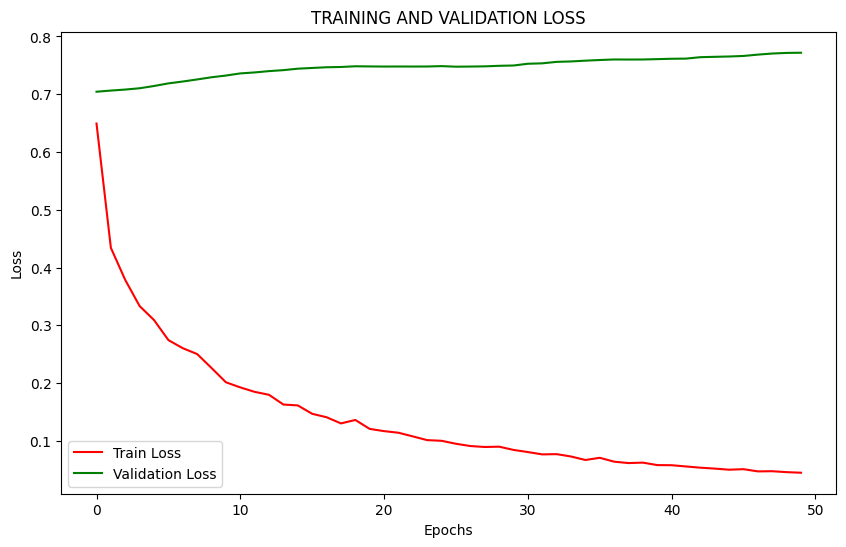

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color = 'red')
plt.plot(val_losses, label='Validation Loss', color = 'green')
plt.title('TRAINING AND VALIDATION LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
def load_image(image_path, size=(224, 224)):
    """
    Load an image from a file path and preprocess it.

    Parameters:
        image_path (str): The path to the image file.
        size (tuple): The target size of the image (width, height).

    Returns:
        numpy.ndarray: The preprocessed image as a numpy array.
    """
    if not os.path.exists(image_path):
        print(f"Error: The specified file does not exist - {image_path}")
        return None

    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB').resize(size)
            img_array = np.array(img)
            img_array = img_array / 255.0

            return img_array
    except Exception as e:
        print(f"An error occurred while loading the image: {e}")
        return None


In [ ]:
top_n = 5

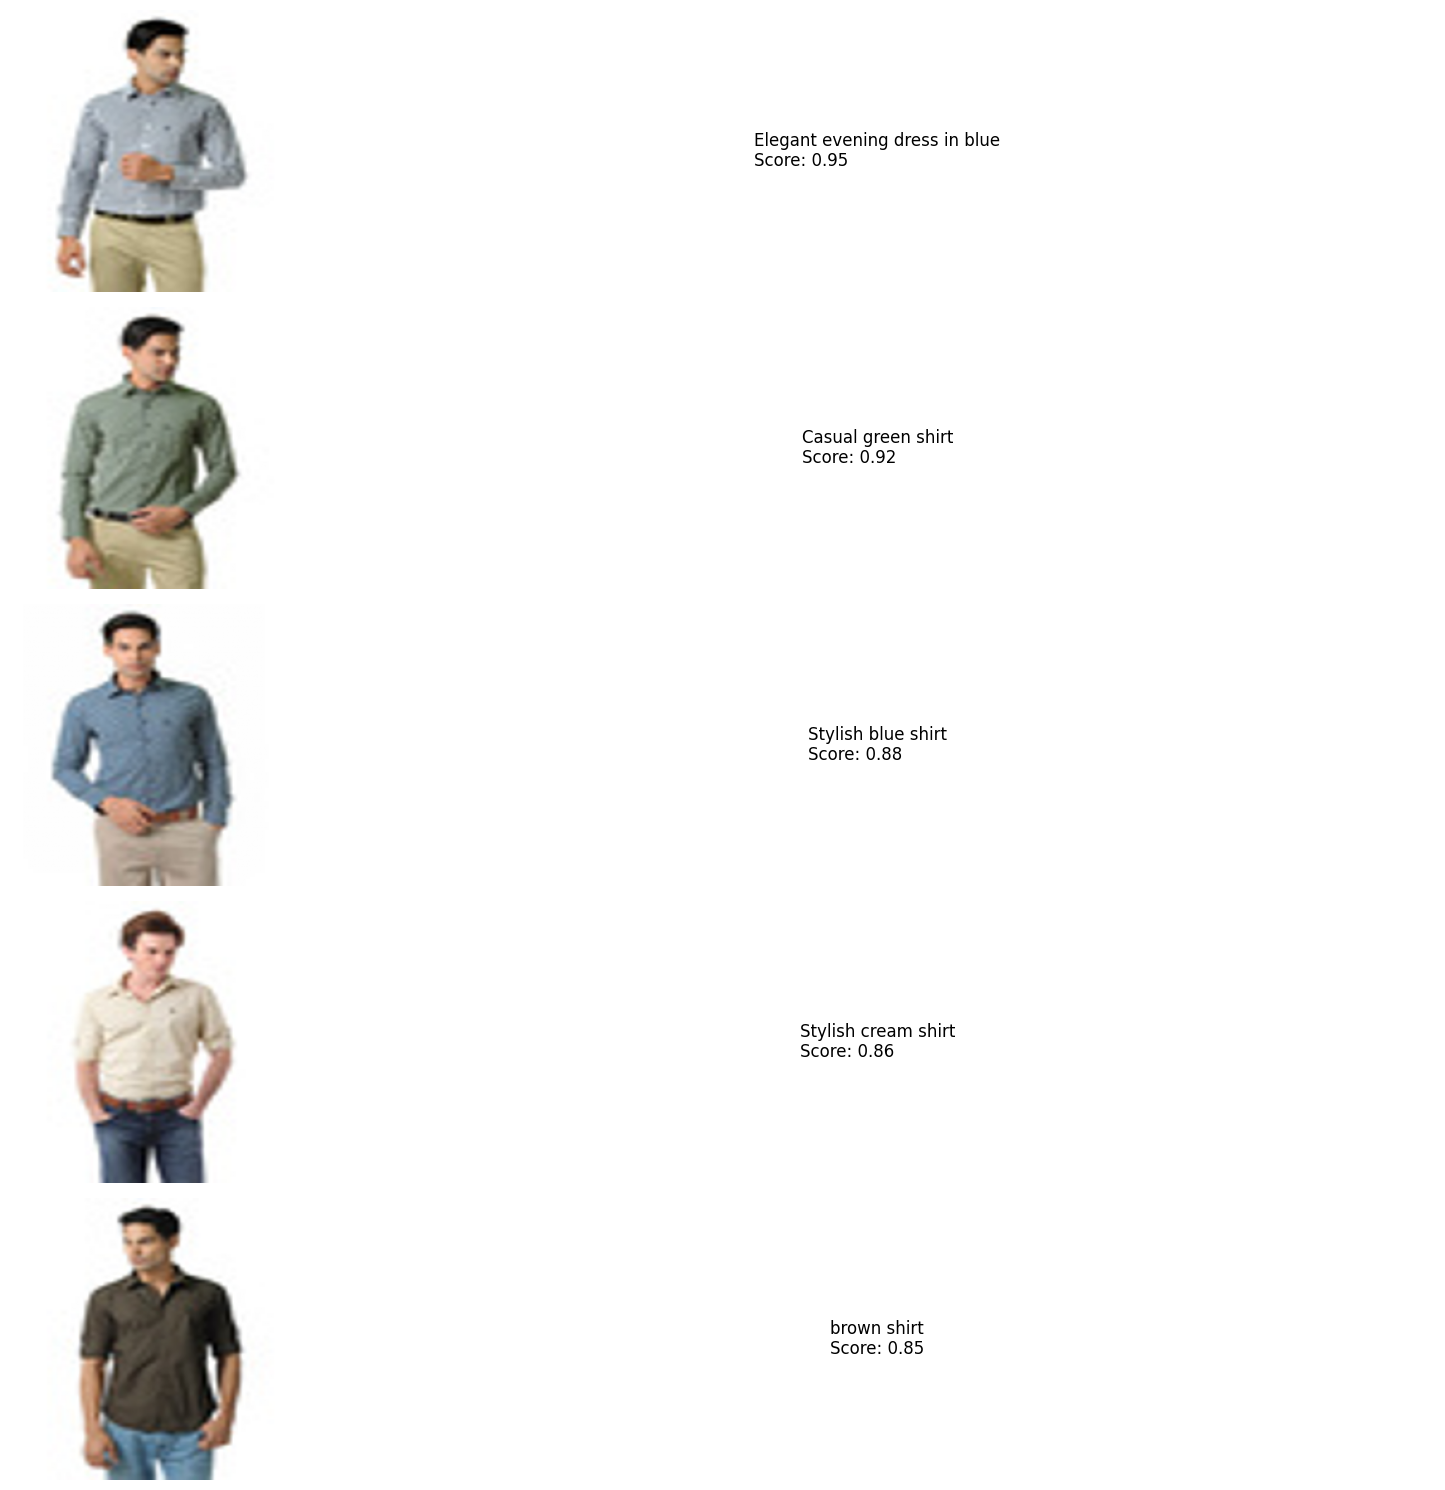

In [ ]:
import matplotlib.gridspec as gridspec

def plot_multimodal_recommendations(images, descriptions, scores, top_n=5):
    fig = plt.figure(figsize=(15, 3 * top_n))
    gs = gridspec.GridSpec(top_n, 2, width_ratios=[1, 3])

    for i in range(top_n):
        if images[i] is not None:
            ax_image = plt.subplot(gs[i, 0])
            ax_image.imshow(images[i])
            ax_image.axis('off')

            ax_text = plt.subplot(gs[i, 1])
            ax_text.text(0.5, 0.5, f'{descriptions[i]}\nScore: {scores[i]:.2f}',
                         verticalalignment='center', horizontalalignment='center',
                         fontsize=12, multialignment='left')
            ax_text.axis('off')
        else:
            print(f"Failed to load image at index {i}")

    plt.tight_layout()
    plt.show()

image_paths = [
    r'e-commerce\images\59297.jpg',
    r'e-commerce\images\59298.jpg',
    r'e-commerce\images\59299.jpg',
    r'e-commerce\images\59300.jpg',
    r'e-commerce\images\59301.jpg'
]

sample_images = [load_image(path) for path in image_paths]

sample_descriptions = [
    "Elegant evening dress in blue",
    "Casual green shirt",
    "Stylish blue shirt",
    "Stylish cream shirt",
    "brown shirt"
]
sample_scores = [0.95, 0.92, 0.88, 0.86, 0.85]
plot_multimodal_recommendations(sample_images, sample_descriptions, sample_scores, top_n=top_n)


In [ ]:
for i in range(len(sample_images)):
    print(f"Index: {i}, Description: {sample_descriptions[i]}")


Index: 0, Description: Elegant evening dress in blue
Index: 1, Description: Casual green shirt
Index: 2, Description: Stylish blue shirt
Index: 3, Description: Stylish cream shirt
Index: 4, Description: brown shirt
